# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create test set and define test dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?
- The first transformation is to transform the images from the dataset into Pytorch tensors because Pytorch and nueral networks in genral work with tensors, this also scales the pixxel values from [0,255] to [0,1].
- The second transformation is to normalize the pixel values of the image giving the a mean of 0.5 and a standard deviation of 0.5, this normalization helps the model to converge faster during the training phase and makes it easier for algorithms like gradient descent to reach the global minimun.
- The third transformation is to flatten the images, for this one i used the lambda function with the view(-1) methode, we flatten the images because the model is expecting a vector rather than a 2D matrix and the view methode reshapes the tensor while keeping the total number of values constant, for the 28x28 images that we have the flatened output will be 28 * 28 = 784 values.


**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


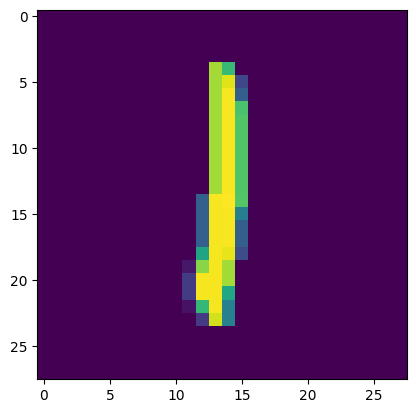

7


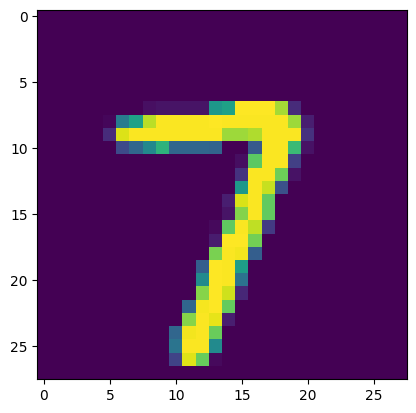

6


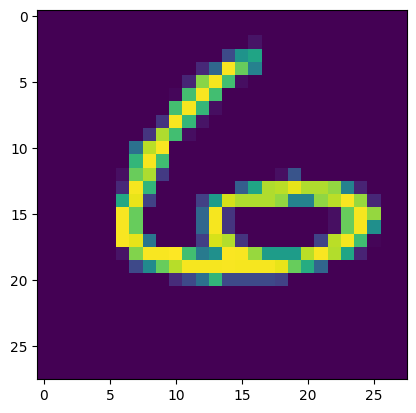

7


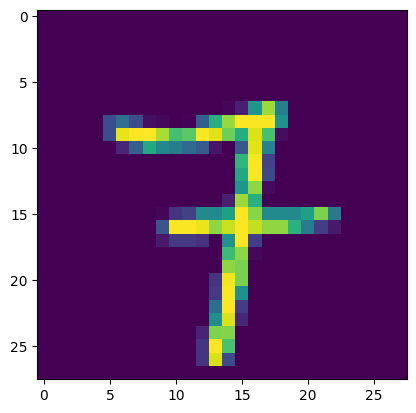

6


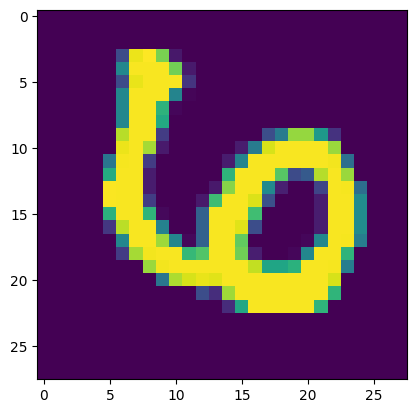

In [4]:
# Explore data
temp_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

temp_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=temp_transform)

temp_loader = torch.utils.data.DataLoader(temp_train, batch_size=64, shuffle=True)
show5(temp_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)   
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
import matplotlib.pyplot as plt

def train_model(net, criterion, optimizer, num_epochs=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        net.train()
        train_loss = 0.0
        train_correct = 0
        total_train_samples = 0

        for inputs, labels in train_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item() * inputs.size(0)
            total_train_samples += inputs.size(0)

        train_acc = train_correct / total_train_samples
        train_loss_avg = train_loss / total_train_samples

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)

        # Validation Phase
        net.eval()
        val_loss = 0.0
        val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                if torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)

        val_acc = val_correct / total_val_samples
        val_loss_avg = val_loss / total_val_samples

        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Train Acc: {train_acc:.2%}, Train Loss: {train_loss_avg:.4f} - "
              f"Val Acc: {val_acc:.2%}, Val Loss: {val_loss_avg:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

Plot the training loss (and validation loss/accuracy, if recorded).

In [8]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(net, criterion, optimizer, num_epochs=5)

Epoch 1/5 - Train Acc: 89.77%, Train Loss: 0.3403 - Val Acc: 93.80%, Val Loss: 0.1986
Epoch 2/5 - Train Acc: 95.39%, Train Loss: 0.1517 - Val Acc: 94.56%, Val Loss: 0.1748
Epoch 3/5 - Train Acc: 96.45%, Train Loss: 0.1130 - Val Acc: 96.91%, Val Loss: 0.1009
Epoch 4/5 - Train Acc: 97.20%, Train Loss: 0.0895 - Val Acc: 96.88%, Val Loss: 0.0984
Epoch 5/5 - Train Acc: 97.61%, Train Loss: 0.0768 - Val Acc: 97.35%, Val Loss: 0.0826


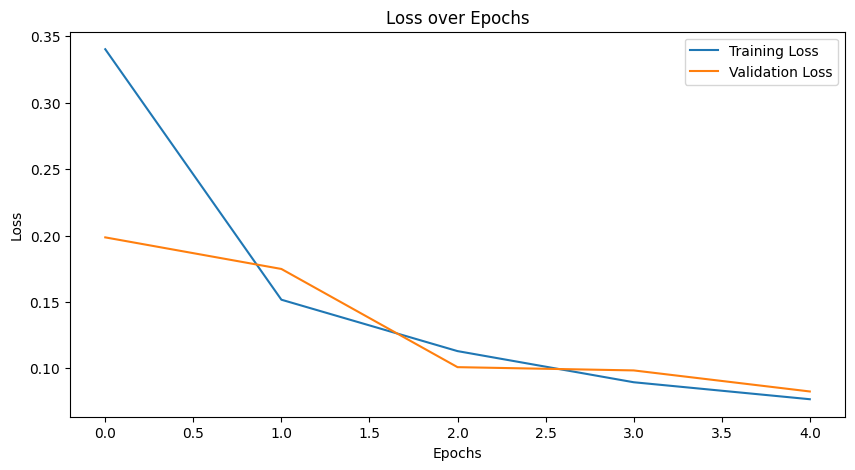

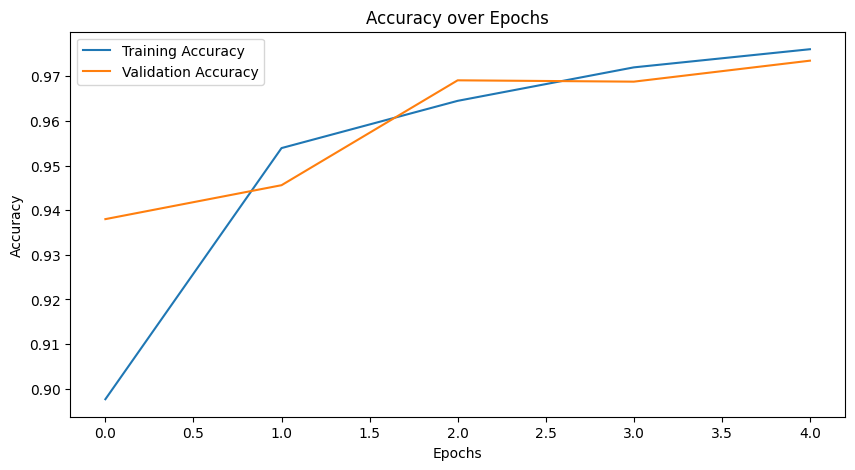

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
def test_model(net):
    net.eval() 
    correct = 0
    total = 0

    with torch.no_grad(): 
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) 
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [11]:
test_accuracy = test_model(net)

Test Accuracy: 97.35%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [12]:
## I got 97% so i think if i tweak it, it will get lower :\ ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
torch.save(net.state_dict(), 'model.pth')